<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Seasonal forecast anomalies

### About

This notebook provides you a practical introduction to calculating seasonal forecast anomalies.


The notebook has the following outline:

* [1 - Calculate seasonal hindcast climate mean](#hindcast_climate_mean)
* [2 - Load monthly seasonal forecast data for September 2021](#seasonal_forecast_load)
* [3 - Calculate seasonal forecast anomalies for September 2021](#seasonal_anomalies_calculate)
* [4 - Compare the calculated anomalies with the seasonal forecast anomalies offered by the CDS](#seasonal_anomalies_compare)

### Data

This notebook introduces you to the `seasonal forecast monthly statistics` and `seasonal forecast anomalies` on single levels. The data used in the notebook has the following specifications:

> **Data**: `Seasonal forecast monthly statistics on single levels - Hindcast data` <br>
> **Temporal coverage**: `Sep 1993 to Sep 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve requests**: 
> * [CDS API request - Hindcast individual members](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast)
> * [CDS API request - Hindcast climate mean](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast_mean)

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Forecast data` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#seas5_monthly_forecast)

<br>

> **Data**: `Seasonal forecast anomalies on single levels` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#seas5_monthly_anomalies)

<br>

Get [here](./101_c3s_data_intro.ipynb#seasonal_forecasts) more information about seasonal forecast data in general including an overview of the different dataset types.

### Further resources

<br>

<hr>

### Load libraries

In [3]:
# CDS API
import cdsapi

import cfgrib
# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd



# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Load helper functions

In [4]:
%run ./functions.ipynb

<hr>

## <a id='hindcast_climate mean'></a>1. Calculate seasonal hindcast climate mean

The example below will show you how to calculate seasonal forecast anomalies of total precipitation for September 2021 and for five leadtime months (until February 2022). 
The term anomaly refers to the deviation of a value from the long-term average. A positive anomaly indicates that the average precipitation of this month was higher than the reference value, while a negative anomaly indicates that during this specific month, it rained less and it was drier than the reference value.

The first step is to calculate the hindcast climate mean for September, which is the longterm average of precipitation for seasonal forecasts with a start runtim in September and five lead time months (until February). The reference period for the seasonal hindcast data is from 1993 to 2016 and the hindcast climate mean represents the average conditions observed over this period. 

Seasonal forecast data are disseminated in the `GRIB` data format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read GRIB files from ECMWF. To read a GRIB file, you have to specify the keyword argument `engine` and specify `'cfgrib'`. [cfgrib](https://github.com/ecmwf/cfgrib) is a Python interface to map GRIB files to the NetCDF Common Data Model using [ecCodes](https://github.com/ecmwf/eccodes).

The result is a `xarray.Dataset` object with five dimensions: `number`, `time`, `step`, `latitude` and `longitude`. 

In [5]:
ds = xr.open_dataset('./data/ecmwf_seas5_1993-2016_09_hindcast_monthly_tp.grib', engine='cfgrib')
ds

<xarray.Dataset>
Dimensions:     (number: 25, time: 24, step: 7, latitude: 181, longitude: 360)
Coordinates:
  * number      (number) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
  * step        (step) timedelta64[ns] 30 days 61 days ... 181 days 182 days
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    tprate      (number, time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-14T15:38 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

Per default, xarray does not load the GRIB file in a structure useful for us. Let us arrange the `xarray.Dataset` with the following dimensions:


You can specify a custom data structure by identifying the keyword argument `backend_kwargs` and specifically highligting the two dimensions that shall be used for the time dimensions. When you do this, you see that the resulting `xarray.Dataset` has five dimensions:
* `number`: Number of ensembles (25)
* `forecastMonth`: leadtime months (6, including the startime run)
* `time`: number of years (24, from 1993 to 2016)
* `latitude`: latitudes (181 -> 1 deg resolution)
* `longitude`: longitudes (360 --> 1 deg resolution)

In [6]:
ds_hindcast = xr.open_dataset('./data/ecmwf_seas5_1993-2016_09_hindcast_monthly_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_hindcast

<xarray.Dataset>
Dimensions:        (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    tprate         (number, forecastMonth, time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-14T15:39 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load the data variable `tprate` as `xarray.DataArray`. You can load a DataArray from a Dataset by specifying the name of the variable in square brackets `[]`. A xarray.DataArray provides you additional attributes of the variable. For example, you see that the precipitation is given in accumulations with the unit m/s. Since these conversion from precipitation rate in m/s to total precipitation for a month in m depends on the number of days per month, we will execute the conversion in a later step. You find more information about the conversion of accumulated variables [here](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790).

In [7]:
tprate_hindcast = ds_hindcast['tprate']
tprate_hindcast

<xarray.DataArray 'tprate' (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)>
[234576000 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             172228
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tprate
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                Total precipitation
    units:                                    m s**-1
    standard_name:                            unknown

Since we are interested in creating the `hindcast climate mean`, the next step is to create the average over the 25 ensemble members and the 24 start years. You can use the function `mean()` in order to average over one or more given dimensions. The dimension we want to create the longterm mean are `number` (25 ensemble members) and `time` (start time years from 1993 to 2016). The result is a `xarray.DataArray` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

The DataArray `tprate_hindcast_mean` is the hindcast climate mean for the month September and five leadtime months, over the reference period 1993 to 2016.

**Note:** with the averaging operation, your `xarray.DataArray` loses its attributes. Before the final visualisation of the computed anomalies ([here](#seas5_anomalies)), we will show you how to add and modify attributes of a xarray.DataArray.

In [8]:
tprate_hindcast_mean = tprate_hindcast.mean(['number', 'time'])
tprate_hindcast_mean

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[1.30519284e-08, 1.30519284e-08, 1.30519284e-08, ...,
         1.30519284e-08, 1.30519284e-08, 1.30519284e-08],
        [1.29193847e-08, 1.29264786e-08, 1.29335120e-08, ...,
         1.28761171e-08, 1.28908137e-08, 1.29050388e-08],
        [1.27145787e-08, 1.27424329e-08, 1.27702879e-08, ...,
         1.26161463e-08, 1.26491306e-08, 1.26819577e-08],
        ...,
        [1.59635727e-09, 1.58900848e-09, 1.58193869e-09, ...,
         1.61743330e-09, 1.61039981e-09, 1.60347557e-09],
        [2.02993156e-09, 2.02502037e-09, 2.02016959e-09, ...,
         2.04188844e-09, 2.03753481e-09, 2.03377559e-09],
        [2.38863618e-09, 2.38863618e-09, 2.38863618e-09, ...,
         2.38863618e-09, 2.38863618e-09, 2.38863618e-09]],

       [[9.31883282e-09, 9.31883282e-09, 9.31883282e-09, ...,
         9.31883282e-09, 9.31883282e-09, 9.31883282e-09],
        [9.47422318e-09, 9.47830969e-09, 9.48284473e-09, ...,
         9.45015177e-09, 9.45828837e-09, 9.46614698e-09],
        [9.54022727e-09, 9.55950874e-09, 9.57912949e-09, ...,
         9.45883460e-09, 9.48605816e-09, 9.51313694e-09],
...
        [9.28015720e-10, 9.25384325e-10, 9.22122267e-10, ...,
         9.37474542e-10, 9.35328148e-10, 9.31981159e-10],
        [1.12467280e-09, 1.12765597e-09, 1.12905052e-09, ...,
         1.12102272e-09, 1.12257492e-09, 1.12303578e-09],
        [1.43433732e-09, 1.43433732e-09, 1.43433732e-09, ...,
         1.43433732e-09, 1.43433732e-09, 1.43433732e-09]],

       [[4.48322357e-09, 4.48322357e-09, 4.48322357e-09, ...,
         4.48322357e-09, 4.48322357e-09, 4.48322357e-09],
        [4.71520556e-09, 4.71795225e-09, 4.71878270e-09, ...,
         4.71338035e-09, 4.71536943e-09, 4.71564832e-09],
        [4.97592767e-09, 4.99264408e-09, 5.00930586e-09, ...,
         4.93878982e-09, 4.95157160e-09, 4.96347985e-09],
        ...,
        [1.52525936e-09, 1.52063917e-09, 1.51525492e-09, ...,
         1.54213353e-09, 1.53621571e-09, 1.52983115e-09],
        [1.83119542e-09, 1.82910354e-09, 1.82867910e-09, ...,
         1.83600357e-09, 1.83390569e-09, 1.83308713e-09],
        [2.18982832e-09, 2.18982832e-09, 2.18982832e-09, ...,
         2.18982832e-09, 2.18982832e-09, 2.18982832e-09]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

`TO BE CHECKED`

In [9]:
hindcast_climate_mean = xr.open_dataset('./data/ecmwf_seas5_hincast_climate_mean_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))

test = hindcast_climate_mean['tprate']
test

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 181, longitude: 360)>
[390960 values with dtype=float32]
Coordinates:
    number         int64 ...
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             172228
    GRIB_dataType:                            hcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tprate
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                Total precipitation
    units:                                    m s**-1
    standard_name:                            unknown

<br>

## <a id='seasonal_forecast_load'></a>2. Load monthly seasonal forecast data for September 2021

The next step is to load the real-time seasonal forecast data for September 2021 and five leadtime months. We open the dataset `ecmwf_seas5_2021_09_forecast_monthly_tp.grib` with the xarray function `open_dataset()`, where we again specify the two keyword arguments `engine` and `backend_kwargs`. See [here](.100_climate_data_store_intro.ipynb#seas5_monthly_forecast) the CDS API data request used.

Once the the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
* `number`: 51 ensemble members
* `forecastMonth`: 6 leadtime months, including September, the month of the model run
* `latitude`: latitude values
* `longitude`: longitude values

Compared to the hindcast data, we do not have the dimension `time`, as the data only holds information for the year 2021. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, who only have 25 ensemble members.

In [11]:
seas5_forecast = xr.open_dataset('./data/ecmwf_seas5_2021_09_forecast_monthly_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
seas5_forecast

<xarray.Dataset>
Dimensions:        (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    tprate         (number, forecastMonth, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-14T16:08 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

Now, we can also build the average over the 51 ensemble members of the seasonal forecast data for September 2021. You can use the xarray function `mean()` and specify the dimension name `number` to do so. The result is a `xarray.Dataset` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

**Note**: as a result of the averaging process, the xarray.Dataset looses again its attribute information.

In [12]:
seas5_forecast_mean = seas5_forecast.mean(['number'])
seas5_forecast_mean

<xarray.Dataset>
Dimensions:        (forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    tprate         (forecastMonth, latitude, longitude) float32 1.225e-08 ......

Now, we have loaded and prepared the two dataset we require and we can continue to calculate the seasonal forecast anomalies for September 2021.

<br>

## <a id='seas5_anomalies'></a> 3. Calculate seasonal forecast anomalies for September 2021

Now, we can compute the seasonal forecast anomalies for September 2021. You can compute the anomalies by subtracting the longterm average (`tprate_hindcast_mean`) from the seasonal forecast real-time data for September 2021 (`seas5_forecast_mean`).

The resulting `xarray.DataArray` has the anomaly information for each of the leadtime months from September 2021 to February 2022 relative to the reference period September 1993 to 2016.

In [13]:
seas5_anomalies_202109 = seas5_forecast_mean['tprate'] - tprate_hindcast_mean
seas5_anomalies_202109

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[-7.9992901e-10, -7.9992901e-10, -7.9992901e-10, ...,
         -7.9992901e-10, -7.9992901e-10, -7.9992901e-10],
        [-6.5896799e-10, -6.6634698e-10, -6.7623418e-10, ...,
         -6.4865624e-10, -6.5236794e-10, -6.5603523e-10],
        [-2.8438940e-10, -3.2579717e-10, -3.6934544e-10, ...,
         -1.9294788e-10, -2.2307933e-10, -2.5348079e-10],
        ...,
        [-2.0222668e-10, -1.9801660e-10, -1.9608282e-10, ...,
         -2.1217483e-10, -2.0899327e-10, -2.0606372e-10],
        [-2.8070579e-10, -2.8121583e-10, -2.8007441e-10, ...,
         -2.8353198e-10, -2.8217439e-10, -2.8112579e-10],
        [-3.2754288e-10, -3.2754288e-10, -3.2754288e-10, ...,
         -3.2754288e-10, -3.2754288e-10, -3.2754288e-10]],

       [[ 7.5276674e-10,  7.5276674e-10,  7.5276674e-10, ...,
          7.5276674e-10,  7.5276674e-10,  7.5276674e-10],
        [ 9.5589581e-10,  9.6051167e-10,  9.6610542e-10, ...,
          9.3174624e-10,  9.4158548e-10,  9.4827879e-10],
        [ 1.1448353e-09,  1.1597932e-09,  1.1751258e-09, ...,
          1.0804238e-09,  1.1032757e-09,  1.1229915e-09],
...
        [-3.9325376e-11, -4.4825921e-11, -4.3703874e-11, ...,
         -4.0794923e-11, -4.0360493e-11, -4.2006787e-11],
        [-4.5523585e-11, -4.9790727e-11, -4.8617332e-11, ...,
         -4.8436144e-11, -4.8989590e-11, -4.6169180e-11],
        [ 4.3848258e-11,  4.3848258e-11,  4.3848258e-11, ...,
          4.3848258e-11,  4.3848258e-11,  4.3848258e-11]],

       [[ 3.9743897e-10,  3.9743897e-10,  3.9743897e-10, ...,
          3.9743897e-10,  3.9743897e-10,  3.9743897e-10],
        [ 1.2094503e-10,  1.2447554e-10,  1.3120660e-10, ...,
          1.0522250e-10,  1.0922507e-10,  1.1322632e-10],
        [ 6.6803008e-11,  7.0345063e-11,  7.2943429e-11, ...,
          7.5407680e-11,  7.0329964e-11,  6.6981531e-11],
        ...,
        [-1.8359536e-11, -7.3193673e-12, -1.1493806e-11, ...,
         -1.2835288e-11, -1.2766677e-11, -1.7795321e-11],
        [ 1.4521717e-10,  1.5201684e-10,  1.4773349e-10, ...,
          1.5039547e-10,  1.5006818e-10,  1.4960266e-10],
        [ 2.4896396e-10,  2.4896396e-10,  2.4896396e-10, ...,
          2.4896396e-10,  2.4896396e-10,  2.4896396e-10]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

Above, if you have a closer look at the `longitude` information, you see that per default, seasonal forecast data are disseminated on a longitude grid ranging from [0, 360]. For standard visualisations with the plotting library [matplotlib](https://matplotlib.org/), it is better to assign the coordinates to a grid from [-180, 180]. You can use the xarray function `assign_coords` to reassign the longitude values. After the values have been reassigned, you have to sort the longitude values. For sorting, you can use the function `sortby()`.

A check of the data array shows you that the longitude values now range from [-180, 180] and are also sorted in an ascending order.

In [31]:
seas5_anomalies_202109_tp_new = seas5_anomalies_202109_tp.assign_coords(longitude=(((seas5_anomalies_202109_tp.longitude + 180) % 360) - 180)).sortby('longitude')
seas5_anomalies_202109_tp_new

<xarray.DataArray 'tprate' (latitude: 181, longitude: 360)>
array([[-2.073416  , -2.073416  , -2.073416  , ..., -2.073416  ,
        -2.073416  , -2.073416  ],
       [-4.3139567 , -4.3204727 , -4.325139  , ..., -4.1915717 ,
        -4.2306714 , -4.273287  ],
       [-5.363028  , -5.357583  , -5.3469057 , ..., -5.322277  ,
        -5.333107  , -5.349326  ],
       ...,
       [-0.35870707, -0.3463488 , -0.3319566 , ..., -0.42735484,
        -0.40336293, -0.38301355],
       [-0.57418597, -0.57496583, -0.5771384 , ..., -0.5813111 ,
        -0.58145213, -0.5756519 ],
       [-0.84899116, -0.84899116, -0.84899116, ..., -0.84899116,
        -0.84899116, -0.84899116]], dtype=float32)
Coordinates:
    forecastMonth  int64 1
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 -180.0 -179.0 -178.0 ... 178.0 179.0

<br>

Before visualizing the seasonal forecast anomalies, let us convert the precipitation accumulations in m/s to total precipitation for a month in mm. The conversion has to be done per month, as it is dependent on the number of days of a specific month. Let us start with e.g. the values for September. We multiply the accumulations with 30 (for 30 days in September), then with (24 * 60 * 60) to retrieve precipitation values in m. As a last step, you can convert the values in m to precipitation in mm by multiplying the values with 1000.

In [35]:
n_days = 30
seas5_anomalies_202109_tp = seas5_anomalies_202109[0,:,:] * n_days * 24 * 60 * 60 * 1000
seas5_anomalies_202109_tp

<xarray.DataArray 'tprate' (latitude: 181, longitude: 360)>
array([[-2.073416  , -2.073416  , -2.073416  , ..., -2.073416  ,
        -2.073416  , -2.073416  ],
       [-1.708045  , -1.7271713 , -1.752799  , ..., -1.681317  ,
        -1.6909376 , -1.7004434 ],
       [-0.73713726, -0.84446627, -0.95734346, ..., -0.5001209 ,
        -0.5782216 , -0.6570222 ],
       ...,
       [-0.52417153, -0.51325905, -0.5082467 , ..., -0.54995716,
        -0.5417106 , -0.53411716],
       [-0.7275894 , -0.7289114 , -0.7259528 , ..., -0.7349149 ,
        -0.731396  , -0.72867805],
       [-0.84899116, -0.84899116, -0.84899116, ..., -0.84899116,
        -0.84899116, -0.84899116]], dtype=float32)
Coordinates:
    forecastMonth  int64 1
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<br>

As a last step, we can now reassign the attributes to the `xarray.DataArray` above. Let us take the attributes from the original data file `seas5_forecast` and assign it to the DataArray `seas5_anomalies_202109`. You can use the function `assign_attrs()` from the xarray library. Additionally, you want to update the attributes `units` and `long_name`, as they have changed with the previous workflow steps. You can simply specify the name of a attribute (e.g. `units`) and assign it a new value.


In [45]:
seas5_anomalies_202109_tp = seas5_anomalies_202109.assign_attrs(seas5_forecast['tprate'].attrs)
seas5_anomalies_202109_tp

seas5_anomalies_202109_tp.attrs['units'] = 'mm'
seas5_anomalies_202109_tp.attrs['long_name'] = 'Seasonal forecast anomalies of total precipitation (mm) in September 2021'
seas5_anomalies_202109_tp

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[-7.9992901e-10, -7.9992901e-10, -7.9992901e-10, ...,
         -7.9992901e-10, -7.9992901e-10, -7.9992901e-10],
        [-6.5896799e-10, -6.6634698e-10, -6.7623418e-10, ...,
         -6.4865624e-10, -6.5236794e-10, -6.5603523e-10],
        [-2.8438940e-10, -3.2579717e-10, -3.6934544e-10, ...,
         -1.9294788e-10, -2.2307933e-10, -2.5348079e-10],
        ...,
        [-2.0222668e-10, -1.9801660e-10, -1.9608282e-10, ...,
         -2.1217483e-10, -2.0899327e-10, -2.0606372e-10],
        [-2.8070579e-10, -2.8121583e-10, -2.8007441e-10, ...,
         -2.8353198e-10, -2.8217439e-10, -2.8112579e-10],
        [-3.2754288e-10, -3.2754288e-10, -3.2754288e-10, ...,
         -3.2754288e-10, -3.2754288e-10, -3.2754288e-10]],

       [[ 7.5276674e-10,  7.5276674e-10,  7.5276674e-10, ...,
          7.5276674e-10,  7.5276674e-10,  7.5276674e-10],
        [ 9.5589581e-10,  9.6051167e-10,  9.6610542e-10, ...,
          9.3174624e-10,  9.4158548e-10,  9.4827879e-10],
        [ 1.1448353e-09,  1.1597932e-09,  1.1751258e-09, ...,
          1.0804238e-09,  1.1032757e-09,  1.1229915e-09],
...
        [-3.9325376e-11, -4.4825921e-11, -4.3703874e-11, ...,
         -4.0794923e-11, -4.0360493e-11, -4.2006787e-11],
        [-4.5523585e-11, -4.9790727e-11, -4.8617332e-11, ...,
         -4.8436144e-11, -4.8989590e-11, -4.6169180e-11],
        [ 4.3848258e-11,  4.3848258e-11,  4.3848258e-11, ...,
          4.3848258e-11,  4.3848258e-11,  4.3848258e-11]],

       [[ 3.9743897e-10,  3.9743897e-10,  3.9743897e-10, ...,
          3.9743897e-10,  3.9743897e-10,  3.9743897e-10],
        [ 1.2094503e-10,  1.2447554e-10,  1.3120660e-10, ...,
          1.0522250e-10,  1.0922507e-10,  1.1322632e-10],
        [ 6.6803008e-11,  7.0345063e-11,  7.2943429e-11, ...,
          7.5407680e-11,  7.0329964e-11,  6.6981531e-11],
        ...,
        [-1.8359536e-11, -7.3193673e-12, -1.1493806e-11, ...,
         -1.2835288e-11, -1.2766677e-11, -1.7795321e-11],
        [ 1.4521717e-10,  1.5201684e-10,  1.4773349e-10, ...,
          1.5039547e-10,  1.5006818e-10,  1.4960266e-10],
        [ 2.4896396e-10,  2.4896396e-10,  2.4896396e-10, ...,
          2.4896396e-10,  2.4896396e-10,  2.4896396e-10]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             172228
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tprate
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                Seasonal forecast anomalies of ...
    units:                                    mm
    standard_name:                            unknown

Now, we can visualize the seasonal forecast anomalies for September 2021. You can use the function [visualize_pcolormesh()](./functions.ipynb#visualize_pcolormesh) to visualize the global seasonal forecast anomalies with the libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). <br>
The function takes the following keyword arguments:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color_scale`
* `unit`


(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f972b154400>)

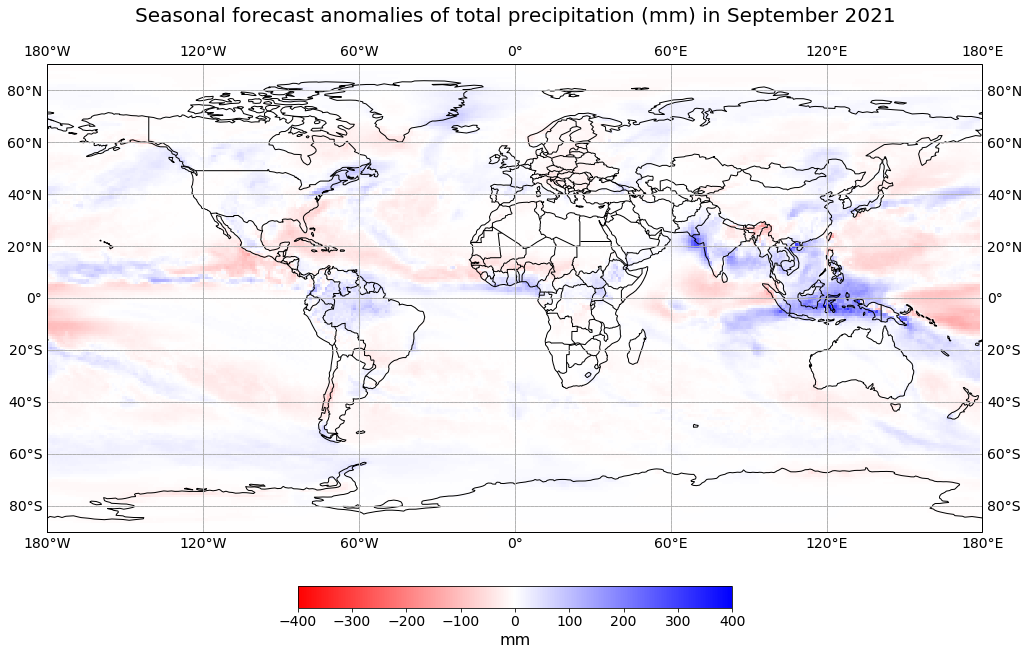

In [46]:
visualize_pcolormesh(data_array = seas5_anomalies_202109_tp_new, 
                     longitude = seas5_anomalies_202109_tp_new.longitude, 
                     latitude = seas5_anomalies_202109_tp_new.latitude, 
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'bwr_r', 
                     unit = seas5_anomalies_202109_tp.units, 
                     long_name = seas5_anomalies_202109_tp.long_name+ '\n', 
                     vmin= -400,
                     vmax = 400, 
                     set_global=True)

<br>

## <a id=''></a> 4. Compare the calculated anomalies with precomputed seasonal forecast anomalies offered by the CDS

In [25]:
anomalies_precomputed = xr.open_dataset('./data/ecmwf_seas5_anomalies_2021_09_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
anomalies_precomputed['tpara']

<xarray.DataArray 'tpara' (forecastMonth: 6, latitude: 181, longitude: 360)>
[390960 values with dtype=float32]
Coordinates:
    number         int64 ...
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             173228
    GRIB_dataType:                            em
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tpara
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                Total precipitation anomalous r...
    units:                                    m s**-1
    standard_name:                            unknown

In [28]:
anomalies_precomputed = test.assign_coords(longitude=(((test.longitude + 180) % 360) - 180)).sortby('longitude')
anomalies_precomputed

<xarray.DataArray 'tpara' (latitude: 181, longitude: 360)>
array([[-2.0729003 , -2.0729003 , -2.0729003 , ..., -2.0729003 ,
        -2.0729003 , -2.0729003 ],
       [-1.7051443 , -1.7240036 , -1.7522925 , ..., -1.6768553 ,
        -1.686285  , -1.7051443 ],
       [-0.73389125, -0.847047  , -0.96020263, ..., -0.49815023,
        -0.57358736, -0.6584541 ],
       ...,
       [-0.5264392 , -0.5170095 , -0.50757986, ..., -0.54529846,
        -0.54529846, -0.5358688 ],
       [-0.7244616 , -0.7244616 , -0.7244616 , ..., -0.73389125,
        -0.73389125, -0.7244616 ],
       [-0.847047  , -0.847047  , -0.847047  , ..., -0.847047  ,
        -0.847047  , -0.847047  ]], dtype=float32)
Coordinates:
    number         int64 0
    forecastMonth  int64 1
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... -4.0 -3.0 -2.0 -1.0

In [27]:

test = anomalies_precomputed['tpara'][0,:,:] * 30 * 24 * 60 * 60 * 1000
test

<xarray.DataArray 'tpara' (latitude: 181, longitude: 360)>
array([[-2.0729003 , -2.0729003 , -2.0729003 , ..., -2.0729003 ,
        -2.0729003 , -2.0729003 ],
       [-1.7051443 , -1.7240036 , -1.7522925 , ..., -1.6768553 ,
        -1.686285  , -1.7051443 ],
       [-0.73389125, -0.847047  , -0.96020263, ..., -0.49815023,
        -0.57358736, -0.6584541 ],
       ...,
       [-0.5264392 , -0.5170095 , -0.50757986, ..., -0.54529846,
        -0.54529846, -0.5358688 ],
       [-0.7244616 , -0.7244616 , -0.7244616 , ..., -0.73389125,
        -0.73389125, -0.7244616 ],
       [-0.847047  , -0.847047  , -0.847047  , ..., -0.847047  ,
        -0.847047  , -0.847047  ]], dtype=float32)
Coordinates:
    number         int64 0
    forecastMonth  int64 1
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9729561320>)

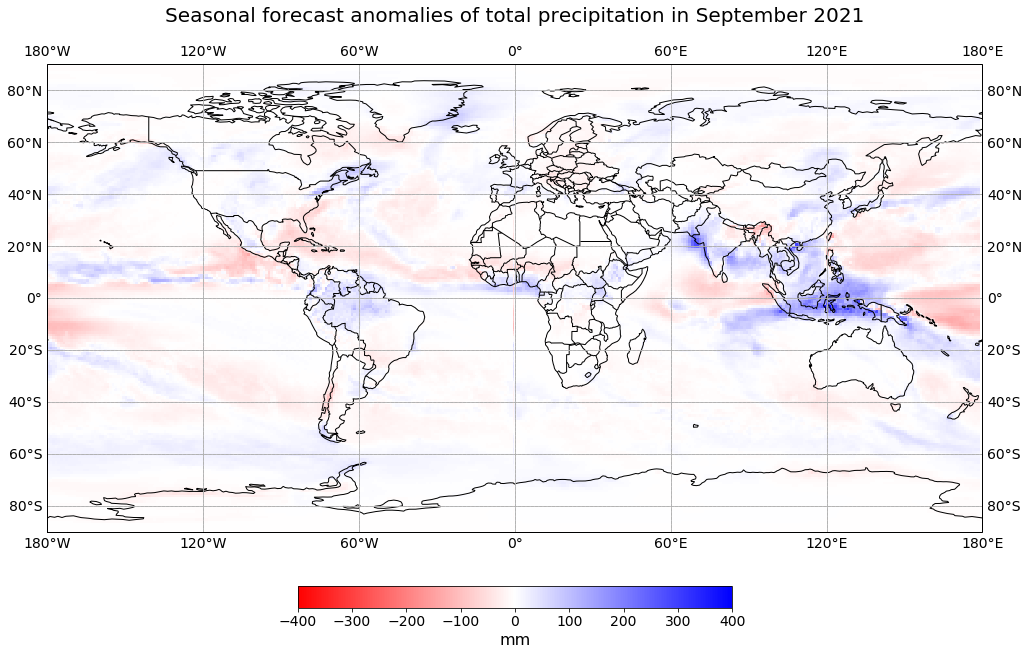

In [29]:
visualize_pcolormesh(data_array = anomalies_precomputed, 
                     longitude = anomalies_precomputed.longitude, 
                     latitude = anomalies_precomputed.latitude, 
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'bwr_r', 
                     unit = 'mm', 
                     long_name = 'Seasonal forecast anomalies of total precipitation in September 2021\n', 
                     vmin= -400,
                     vmax = 400, 
                     set_global=True)

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>